In [38]:
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pygame
import cv2  # for video capture

# Enable cuDNN benchmarking for performance (if using GPU)
torch.backends.cudnn.benchmark = True

# Constants for gridworld and visualization
GRID_SIZE = 15
CELL_SIZE = 50   # decreased cell size so that the grid is smaller on a 1440p screen
WINDOW_SIZE = GRID_SIZE * CELL_SIZE
NUM_OBSTACLES = 25  # increased number of obstacles

# ----------------------------
# Environment (Gridworld)
# ----------------------------
class Gridworld:
    def __init__(self):
        self.grid_size = GRID_SIZE
        self.cell_size = CELL_SIZE
        self.vision_radius = 5  # drones can sense obstacles within 5 cells
        
        # Define goals:
        # Agent 0's goal is bottom-right; Agent 1's goal is bottom-left.
        self.goals = [(GRID_SIZE - 1, GRID_SIZE - 1), (0, GRID_SIZE - 1)]
        
        self.obstacles = self.generate_obstacles()
        #self.obstacles = [(2, 3), (7, 8), (11, 1), (6, 4), (9, 13),
    #(3, 10), (12, 7), (0, 9), (0, 12), (4, 6),
    #(10, 3), (1, 10), (6, 9), (13, 2), (7, 6),
    #(5, 14), (11, 12), (10, 14), (8, 2), (14, 4),
    #(5, 8), (2, 10), (13, 13), (10, 9), (4, 2)]
        
        # Compute best paths using A* (only considering obstacles)
        self.best_path_agent0 = self.a_star((0, 0), self.goals[0])
        self.best_path_agent1 = self.a_star((0, 0), self.goals[1])
        
        # Congestion zones (dynamic) with a timer
        self.congestion_zones = []
        self.congestion_duration = 50  # congestion zones persist for 50 steps
        self.congestion_timer = 0
        
        # Both agents start at top-left (0,0)
        self.agents = [(0, 0), (0, 0)]
        
        # Penalty and reward values
        self.movement_penalty = -1
        self.closeness_penalty = -10
        self.collision_penalty = -500
        self.congestion_penalty = -20
        self.goal_reward = 10000
        self.shaping_factor = 0.5
        
        # Parameters for following the best path
        self.best_path_bonus = 5
        self.deviation_penalty = -5

    def generate_obstacles(self):
        obstacles = set()
        while len(obstacles) < NUM_OBSTACLES:
            x = random.randint(0, self.grid_size - 1)
            y = random.randint(0, self.grid_size - 1)
            if (x, y) != (0, 0) and (x, y) != (14, 14) and (x, y) not in self.goals:
                obstacles.add((x, y))

        print(obstacles)
        return list(obstacles)

    def heuristic(self, node, goal):
        return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

    def get_neighbors(self, node):
        (x, y) = node
        neighbors = []
        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                if (nx, ny) not in self.obstacles:
                    neighbors.append((nx, ny))
        return neighbors

    def a_star(self, start, goal):
        import heapq
        open_set = []
        heapq.heappush(open_set, (0, start))
        came_from = {}
        g_score = {start: 0}
        while open_set:
            current_f, current = heapq.heappop(open_set)
            if current == goal:
                path = [current]
                while current in came_from:
                    current = came_from[current]
                    path.append(current)
                path.reverse()
                return path
            for neighbor in self.get_neighbors(current):
                tentative_g = g_score[current] + 1
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score = tentative_g + self.heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score, neighbor))
        return []

    def update_congestion_zones(self):
        if self.congestion_timer > 0:
            self.congestion_timer -= 1
            return
        num_zones = 6  # increased number of congestion zones
        possible_zones = list(set(self.best_path_agent0 + self.best_path_agent1))
        if possible_zones:
            self.congestion_zones = random.sample(possible_zones, min(num_zones, len(possible_zones)))
        else:
            self.congestion_zones = []
        self.congestion_timer = self.congestion_duration

    def get_obstacle_view(self, agent_position):
        view = []
        ax, ay = agent_position
        for dy in range(-self.vision_radius, self.vision_radius + 1):
            for dx in range(-self.vision_radius, self.vision_radius + 1):
                cx, cy = ax + dx, ay + dy
                if 0 <= cx < self.grid_size and 0 <= cy < self.grid_size:
                    view.append(1.0 if (cx, cy) in self.obstacles else 0.0)
                else:
                    view.append(0.0)
        return view

    def get_congestion_view(self, agent_position):
        view = []
        ax, ay = agent_position
        for dy in range(-self.vision_radius, self.vision_radius + 1):
            for dx in range(-self.vision_radius, self.vision_radius + 1):
                cx, cy = ax + dx, ay + dy
                if 0 <= cx < self.grid_size and 0 <= cy < self.grid_size:
                    view.append(1.0 if (cx, cy) in self.congestion_zones else 0.0)
                else:
                    view.append(0.0)
        return view

    def reset(self):
        # Randomize agents
        while True:
            start1 = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            start2 = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if start1 not in self.obstacles and start2 not in self.obstacles and start1 != start2:
                break
        self.agents = [start1, start2]
    
        # Randomize goals
        while True:
            goal1 = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            goal2 = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if goal1 not in self.obstacles and goal2 not in self.obstacles and goal1 != goal2:
                break
        self.goals = [goal1, goal2]
    
        # Recompute A* paths
        self.best_path_agent0 = self.a_star(self.agents[0], self.goals[0])
        self.best_path_agent1 = self.a_star(self.agents[1], self.goals[1])
        
        return self.get_states()



    def get_direction_vector(self, pos, goal):
        dx = goal[0] - pos[0]
        dy = goal[1] - pos[1]
        magnitude = math.sqrt(dx**2 + dy**2)
        if magnitude == 0:
            return [0.0, 0.0]  # already at goal
        return [dx / magnitude, dy / magnitude]


    def get_astar_view(self, agent_position, astar_path):
        view = []
        ax, ay = agent_position
        for dy in range(-self.vision_radius, self.vision_radius + 1):
            for dx in range(-self.vision_radius, self.vision_radius + 1):
                cx, cy = ax + dx, ay + dy
                if 0 <= cx < self.grid_size and 0 <= cy < self.grid_size:
                    view.append(1.0 if (cx, cy) in astar_path else 0.0)
                else:
                    view.append(0.0)
        return view

    def get_states(self):
        states = []
        for idx, pos in enumerate(self.agents):
            goal = self.goals[idx]
            base_state = [pos[0], pos[1], goal[0], goal[1]]
            direction = self.get_direction_vector(pos, goal)
            obstacle_view = self.get_obstacle_view(pos)
            congestion_view = self.get_congestion_view(pos)
            astar_path = self.best_path_agent0 if idx == 0 else self.best_path_agent1
            astar_view = self.get_astar_view(pos, astar_path)
            states.append(base_state + direction + obstacle_view + congestion_view + astar_view)
        return states



    def step(self, actions):
        self.update_congestion_zones()
        reward = 0
        reward += self.movement_penalty * len(self.agents)
        
        old_distances = []
        for idx, (x, y) in enumerate(self.agents):
            goal = self.goals[idx]
            old_distances.append(abs(x - goal[0]) + abs(y - goal[1]))
        
        new_positions = []
        for idx, (x, y) in enumerate(self.agents):
            dx, dy = 0, 0
            action = actions[idx]
            if action == 0:
                dy = -1
            elif action == 1:
                dy = 1
            elif action == 2:
                dx = -1
            elif action == 3:
                dx = 1
            new_x, new_y = x + dx, y + dy
            if new_x < 0 or new_x >= self.grid_size or new_y < 0 or new_y >= self.grid_size:
                reward += self.collision_penalty
                new_x, new_y = x, y
            if (new_x, new_y) in self.obstacles:
                reward += self.collision_penalty
                new_x, new_y = x, y
            new_positions.append((new_x, new_y))
        self.agents = new_positions
        
        for idx, pos in enumerate(self.agents):
            if pos in self.congestion_zones:
                reward += self.congestion_penalty
        
        for idx, (x, y) in enumerate(self.agents):
            goal = self.goals[idx]
            new_distance = abs(x - goal[0]) + abs(y - goal[1])
            reward += self.shaping_factor * (old_distances[idx] - new_distance)
        
        for idx, pos in enumerate(self.agents):
            best_path = self.best_path_agent0 if idx == 0 else self.best_path_agent1
            if pos in best_path:
                reward += self.best_path_bonus
            else:
                congestion_view = self.get_congestion_view(pos)
                if not any(cell == 1.0 for cell in congestion_view):
                    reward += self.deviation_penalty
        
        manhattan_distance = abs(self.agents[0][0] - self.agents[1][0]) + abs(self.agents[0][1] - self.agents[1][1])
        if manhattan_distance < 3:
            reward += self.closeness_penalty


                
        for idx, pos in enumerate(self.agents):
            if pos == self.goals[idx]:
                reward += self.goal_reward
        
        done = (self.agents[0] == self.goals[0] and self.agents[1] == self.goals[1])
        next_states = self.get_states()
        return next_states, reward, done

    def render(self, screen):
        screen.fill((255, 255, 255))
        for x in range(0, WINDOW_SIZE, self.cell_size):
            pygame.draw.line(screen, (200, 200, 200), (x, 0), (x, WINDOW_SIZE))
        for y in range(0, WINDOW_SIZE, self.cell_size):
            pygame.draw.line(screen, (200, 200, 200), (0, y), (WINDOW_SIZE, y))
        for obs in self.obstacles:
            rect = pygame.Rect(obs[0]*self.cell_size, obs[1]*self.cell_size, self.cell_size, self.cell_size)
            pygame.draw.rect(screen, (0, 0, 0), rect)
        for cz in self.congestion_zones:
            rect = pygame.Rect(cz[0]*self.cell_size, cz[1]*self.cell_size, self.cell_size, self.cell_size)
            pygame.draw.rect(screen, (255, 165, 0), rect)
        # Draw computed best paths
        if self.best_path_agent0 and len(self.best_path_agent0) > 1:
            points0 = [(x * self.cell_size + self.cell_size//2, y * self.cell_size + self.cell_size//2)
                       for (x, y) in self.best_path_agent0]
            pygame.draw.lines(screen, (255, 0, 255), False, points0, 3)
        if self.best_path_agent1 and len(self.best_path_agent1) > 1:
            points1 = [(x * self.cell_size + self.cell_size//2, y * self.cell_size + self.cell_size//2)
                       for (x, y) in self.best_path_agent1]
            pygame.draw.lines(screen, (0, 255, 255), False, points1, 3)
        # Draw goals with colors matching the drones:
        goal_colors = [(255, 0, 0), (0, 0, 255)]
        for idx, goal in enumerate(self.goals):
            rect = pygame.Rect(goal[0]*self.cell_size, goal[1]*self.cell_size, self.cell_size, self.cell_size)
            pygame.draw.rect(screen, goal_colors[idx], rect)
            
        # Draw agents as circles (agent 0 in red, agent 1 in blue)
        colors = [(255, 0, 0), (0, 0, 255)]
        for idx, pos in enumerate(self.agents):
            center = (pos[0]*self.cell_size + self.cell_size//2,pos[1]*self.cell_size + self.cell_size//2)
            pygame.draw.circle(screen, colors[idx], center, self.cell_size//3)
        pygame.display.flip()

# ----------------------------
# Replay Buffer for DQN
# ----------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# ----------------------------
# DQN Network and Agent (GPU-enabled)
# ----------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, 64),nn.ReLU(),nn.Linear(64, 64),nn.ReLU(),nn.Linear(64, 64),nn.ReLU(),nn.Linear(64, 32),nn.ReLU(),nn.Linear(32, output_dim))

        
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, input_dim, output_dim, lr=1e-3, gamma=0.99, buffer_capacity=10000, batch_size=32):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(input_dim, output_dim).to(self.device)
        self.target_net = DQN(input_dim, output_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        
    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(4)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return q_values.argmax().item()
    
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        transitions = self.replay_buffer.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)
        
        batch_state = torch.FloatTensor(batch_state).to(self.device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(self.device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(self.device)
        batch_next_state = torch.FloatTensor(batch_next_state).to(self.device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(self.device)
        
        current_q = self.policy_net(batch_state).gather(1, batch_action)
        next_q = self.target_net(batch_next_state).max(1)[0].unsqueeze(1)
        target_q = batch_reward + self.gamma * next_q * (1 - batch_done)
        
        loss = nn.MSELoss()(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# ----------------------------
# Training Loop with Milestone Rendering and Video Capture
# ----------------------------
def train():
    num_episodes = 5000
    max_steps = 500
    epsilon_start = 1.0
    epsilon_min = 0.02
    decay_target_episode = int(0.9 * num_episodes)
    epsilon_decay = (epsilon_min / epsilon_start) ** (1 / decay_target_episode)
    
    epsilon = epsilon_start
    target_update_freq = 10
    milestones = {}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    env = Gridworld()
    states = env.reset()
    state_dim = len(states[0])
    action_dim = 4
    agents = [DQNAgent(state_dim, action_dim), DQNAgent(state_dim, action_dim)]

    # Logging structure for last 350 episodes
    path_log = {
        "episode": [],
        "agent0": {"start": [], "goal": [], "path": []},
        "agent1": {"start": [], "goal": [], "path": []},
        "obstacles": []
    }

    for episode in range(num_episodes):
        states = env.reset()
        #print(f"[Episode {episode+1}] Agent 0 Start: {env.agents[0]}, Goal: {env.goals[0]} | Agent 1 Start: {env.agents[1]}, Goal: {env.goals[1]}")
        total_reward = 0
        agent_paths = [[], []]  # to track positions per step

        # Log start and goal if in last 100 episodes
        if episode >= num_episodes - 350:
            path_log["episode"].append(episode + 1)
            path_log["agent0"]["start"].append(env.agents[0])
            path_log["agent1"]["start"].append(env.agents[1])
            path_log["agent0"]["goal"].append(env.goals[0])
            path_log["agent1"]["goal"].append(env.goals[1])
            path_log["obstacles"].append(env.obstacles.copy())

        do_render = (episode + 1) in milestones
        video_writer = None
        if do_render:
            pygame.init()
            screen = pygame.display.set_mode((WINDOW_SIZE, WINDOW_SIZE))
            pygame.display.set_caption(f"Training Episode {episode + 1}")
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            video_filename = f"episode_{episode+1}.mp4"
            fps = 20
            video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (WINDOW_SIZE, WINDOW_SIZE))

        for step in range(max_steps):
            actions = []
            for i in range(2):
                action = agents[i].select_action(states[i], epsilon)
                actions.append(action)
            next_states, reward, done = env.step(actions)
            total_reward += reward

            for i in range(2):
                agents[i].replay_buffer.push(states[i], actions[i], reward, next_states[i], done)

            states = next_states

            for i in range(2):
                agents[i].update()

            # Track paths for both agents
            if episode >= num_episodes - 350:
                for i in range(2):
                    agent_paths[i].append(env.agents[i])

            if do_render:
                env.render(screen)
                frame = pygame.surfarray.array3d(screen)
                frame = np.transpose(frame, (1, 0, 2))
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                video_writer.write(frame)
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        pygame.quit()
                        if video_writer is not None:
                            video_writer.release()
                        return
                pygame.time.wait(50)

            if done:
                break

        if episode >= num_episodes - 350:
            path_log["agent0"]["path"].append(agent_paths[0])
            path_log["agent1"]["path"].append(agent_paths[1])

        if do_render:
            pygame.time.wait(1000)
            pygame.quit()
            if video_writer is not None:
                video_writer.release()

        if (episode + 1) % target_update_freq == 0:
            for agent in agents:
                agent.update_target()

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        print(f"Episode {episode + 1}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    # Save trained models
    for i, agent in enumerate(agents):
        torch.save(agent.policy_net.state_dict(), f"agent_{i}_trained.pth")

    # Save path log
    np.savez("drone_paths_last350episodes.npz", **path_log)
    print("Training complete. Models and path log saved.")


    
if __name__ == '__main__':
    train()


Using device: cuda
{(12, 1), (4, 0), (3, 4), (4, 9), (12, 10), (0, 5), (8, 12), (10, 3), (13, 2), (14, 6), (4, 5), (3, 6), (3, 12), (11, 7), (2, 1), (6, 1), (11, 13), (6, 13), (12, 2), (12, 11), (12, 8), (3, 5), (1, 4), (7, 5), (7, 11)}
Episode 1, Total Reward: -90761.50, Epsilon: 0.999
Episode 2, Total Reward: -75553.50, Epsilon: 0.998
Episode 3, Total Reward: -73910.50, Epsilon: 0.997
Episode 4, Total Reward: -96623.50, Epsilon: 0.997
Episode 5, Total Reward: 46178.00, Epsilon: 0.996
Episode 6, Total Reward: -82176.00, Epsilon: 0.995
Episode 7, Total Reward: -52971.00, Epsilon: 0.994
Episode 8, Total Reward: -46786.50, Epsilon: 0.993
Episode 9, Total Reward: -27811.00, Epsilon: 0.992
Episode 10, Total Reward: -43602.00, Epsilon: 0.991
Episode 11, Total Reward: -24386.00, Epsilon: 0.990
Episode 12, Total Reward: -93429.50, Epsilon: 0.990
Episode 13, Total Reward: -43478.50, Epsilon: 0.989
Episode 14, Total Reward: -66579.00, Epsilon: 0.988
Episode 15, Total Reward: -20942.00, Epsilon:

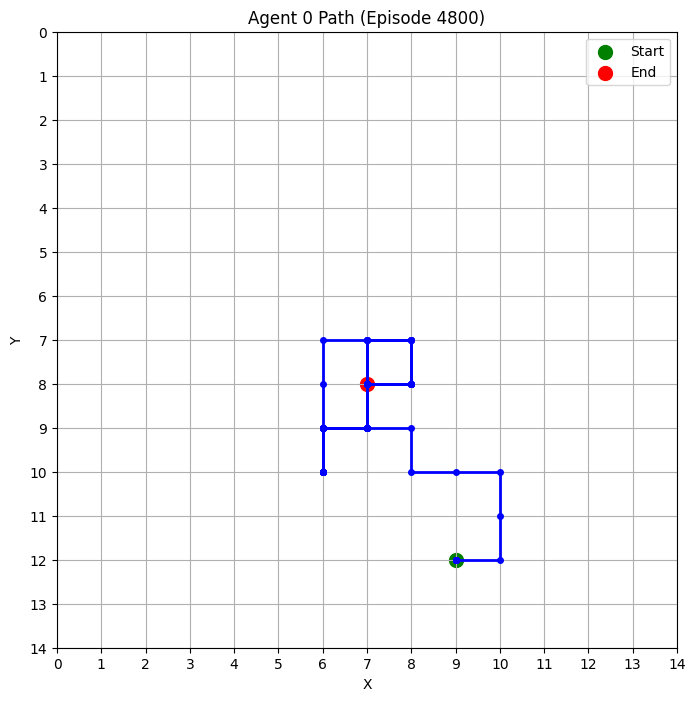

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Extract agent 0 path from first episode (adjust index as needed)
agent0 = data['agent0'].item()
path = agent0['path'][i-4651]  # Change index for different episodes

# Unpack the (x, y) coordinates
x_coords, y_coords = zip(*path)

# Plot the path
plt.figure(figsize=(8, 8))
plt.plot(x_coords, y_coords, marker='o', color='blue', linewidth=2, markersize=4)
plt.scatter([x_coords[0]], [y_coords[0]], color='green', label='Start', s=100)
plt.scatter([x_coords[-1]], [y_coords[-1]], color='red', label='End', s=100)

# Make it look like a grid
plt.gca().invert_yaxis()  # So (0,0) is at the top-left
plt.grid(True, which='both')
plt.xticks(np.arange(0, GRID_SIZE, 1))
plt.yticks(np.arange(0, GRID_SIZE, 1))
plt.title("Agent 0 Path (Episode {})".format(data['episode'][i-4651]))
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.load("drone_paths_final_file.npz", allow_pickle=True)

agent0 = data["agent0"].item()
episodes = data["episode"]
starts = agent0["start"]
goals = agent0["goal"]
final_path = agent0["final_path"]
obstacles = data["obstacles"]

# Select episode number to view

episode_number = 4905


start_episode = episodes[0]  # should be 4651
index = episode_number - start_episode

# Extract data
start = starts[index]
goal = goals[index]
path = final_path[index]
obs = obstacles[index]

print(start)
print(goal)
print(path)


(9, 14)
(9, 1)
[(9, 13), (9, 12), (9, 11), (9, 10), (8, 10), (9, 10), (8, 10), (9, 10), (8, 10), (9, 10), (8, 10), (9, 10), (8, 10), (9, 10), (8, 10), (9, 10), (8, 10), (9, 10), (9, 9), (9, 8), (9, 7), (8, 7), (8, 6), (9, 6), (8, 6), (9, 6), (8, 6), (9, 6), (8, 6), (9, 6), (8, 6), (9, 6), (8, 6), (9, 6), (8, 6), (9, 6), (8, 6), (9, 6), (8, 6), (8, 5), (9, 5), (9, 4), (8, 4), (8, 3), (8, 2), (9, 2), (9, 1)]


In [74]:
import numpy as np

# Load cleaned data
data = np.load("drone_paths_final_file.npz", allow_pickle=True)

agent0 = data["agent0"].item()
episodes = data["episode"]
starts = agent0["start"]
goals = agent0["goal"]
paths = agent0["final_path"]

# Compute distances and collect all relevant data
entries = []
for ep, start, goal, path in zip(episodes, starts, goals, paths):
    distance = np.linalg.norm(np.array(goal) - np.array(start))  # Euclidean
    entries.append((ep, start, goal, path, distance))

# Sort entries by distance descending
entries_sorted = sorted(entries, key=lambda x: x[-1], reverse=True)

# Example: print top 5
print("Top n episodes with longest start-goal distance:")
for ep, start, goal, path, dist in entries_sorted[:50]:
    print(f"Episode {ep}: Distance = {dist:.2f}, Start = {start}, Goal = {goal}, Path Length = {len(path)}")


Top n episodes with longest start-goal distance:
Episode 4813: Distance = 17.69, Start = (14, 1), Goal = (1, 13), Path Length = 93
Episode 4815: Distance = 17.03, Start = (1, 0), Goal = (14, 11), Path Length = 295
Episode 4820: Distance = 16.97, Start = (14, 14), Goal = (2, 2), Path Length = 30
Episode 4876: Distance = 16.40, Start = (0, 13), Goal = (13, 3), Path Length = 82
Episode 4729: Distance = 15.62, Start = (0, 1), Goal = (10, 13), Path Length = 22
Episode 4674: Distance = 15.26, Start = (13, 5), Goal = (0, 13), Path Length = 21
Episode 4944: Distance = 15.26, Start = (0, 6), Goal = (13, 14), Path Length = 21
Episode 4882: Distance = 15.23, Start = (9, 14), Goal = (3, 0), Path Length = 30
Episode 4934: Distance = 15.00, Start = (12, 12), Goal = (0, 3), Path Length = 378
Episode 4997: Distance = 15.00, Start = (0, 9), Goal = (12, 0), Path Length = 218
Episode 4789: Distance = 14.87, Start = (11, 0), Goal = (6, 14), Path Length = 19
Episode 4771: Distance = 14.76, Start = (13, 8),

In [76]:
import numpy as np

# Load cleaned data
data = np.load("drone_paths_final_file.npz", allow_pickle=True)

agent0 = data["agent0"].item()
episodes = data["episode"]
starts = agent0["start"]
goals = agent0["goal"]
paths = agent0["final_path"]

# Compute distances and collect all relevant data
entries = []
for ep, start, goal, path in zip(episodes, starts, goals, paths):
    distance = np.linalg.norm(np.array(goal) - np.array(start))  # Euclidean
    entries.append((ep, start, goal, path, distance))

# Sort entries by distance descending
entries_sorted = sorted(entries, key=lambda x: x[-1], reverse=True)

# Filter and print top entries with path length < 100
print("Top episodes with longest start-goal distance and path length < 100:")
count = 0
for ep, start, goal, path, dist in entries_sorted:
    if len(path) < 100:
        print(f"Episode {ep}: Distance = {dist:.2f}, Start = {start}, Goal = {goal}, Path Length = {len(path)}")
        count += 1
    if count == 50:
        break


Top episodes with longest start-goal distance and path length < 100:
Episode 4813: Distance = 17.69, Start = (14, 1), Goal = (1, 13), Path Length = 93
Episode 4820: Distance = 16.97, Start = (14, 14), Goal = (2, 2), Path Length = 30
Episode 4876: Distance = 16.40, Start = (0, 13), Goal = (13, 3), Path Length = 82
Episode 4729: Distance = 15.62, Start = (0, 1), Goal = (10, 13), Path Length = 22
Episode 4674: Distance = 15.26, Start = (13, 5), Goal = (0, 13), Path Length = 21
Episode 4944: Distance = 15.26, Start = (0, 6), Goal = (13, 14), Path Length = 21
Episode 4882: Distance = 15.23, Start = (9, 14), Goal = (3, 0), Path Length = 30
Episode 4789: Distance = 14.87, Start = (11, 0), Goal = (6, 14), Path Length = 19
Episode 4838: Distance = 14.56, Start = (0, 9), Goal = (14, 13), Path Length = 18
Episode 4702: Distance = 14.21, Start = (14, 2), Goal = (3, 11), Path Length = 22
Episode 4700: Distance = 14.04, Start = (2, 0), Goal = (1, 14), Path Length = 30
Episode 4794: Distance = 14.00,